https://github.com/sunilgoda/nn_text_classification/blob/master/notebooks/NeuralNetworks_TextClassification.ipynb

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras as k

from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten,Dropout,BatchNormalization,Lambda
from keras.layers import Conv1D,MaxPool1D,GlobalMaxPool1D,Embedding
from keras.layers import LSTM,GRU,RNN
from keras.models import Sequential
from keras.optimizers import Adam, Adagrad,Adadelta,Nadam
from keras import callbacks
from keras import regularizers
from keras.utils import plot_model
from keras.models import load_model

from matplotlib import pyplot as plt 
%matplotlib inline

In [3]:
from google.colab import files
test = files.upload()

Saving facebook_health_cases (augmented).csv to facebook_health_cases (augmented).csv


In [4]:
texts = pd.read_csv('facebook_health_cases (augmented).csv')
df = pd.DataFrame(texts)
df

,date,text,cleaned,sentiment
0,20210309,"""Angka semua boleh direka ditambah ditolak ses...",angka direka ditambah ditolak sesuka hati rama...,negative
1,20210309,"""Angka semua boleh direka ditambah ditolak ses...",angka direka ditambah ditolak sesuka benda ram...,negative
2,20210309,"""Angka semua boleh direka ditambah ditolak ses...",angka direka menggandakan ditolak sesuka pokok...,negative
3,20210309,"""Angka semua boleh direka ditambah ditolak ses...",angka direka menggandakan ditolak sesuka benda...,negative
4,20210309,"""Angka semua boleh direka ditambah ditolak ses...",nombor direka menggandakan ditolak sesuka bend...,negative
...,...,...,...,...
42127,20210209,🥺 alhamdulillah semoga kta dapat mcm dlu lgi r...,semoga rakyat malaysia bersatu jangan terpisah...,positive
42128,20210209,🥺 alhamdulillah semoga kta dapat mcm dlu lgi r...,semoga rakyat malaysia bersatu jangan terpisah...,positive
42129,20210209,🥺 alhamdulillah semoga kta dapat mcm dlu lgi r...,semoga negeri malaysia bersatu jangan terpisah...,positive
42130,20210209,🥺 alhamdulillah semoga kta dapat mcm dlu lgi r...,semoga republik malaysia bersama-sama menghent...,positive


In [9]:
from sklearn.model_selection import train_test_split

X_train,X_test,Y_train,Y_test = train_test_split(df['cleaned'],df['sentiment'],test_size = 0.2,random_state = 42)

In [5]:
print("Max length: %s" %df.cleaned.str.len().max())
print("Mean length: %s" %df.cleaned.str.len().mean())
print("Min length: %s" %df.cleaned.str.len().min())

Max length: 1275
Mean length: 100.14922149435108
Min length: 3


In [24]:
MAX_SEQ_LEN = 700
VOCAB_SIZE = 20000

- fits_on_texts:

Updates internal vocabulary based on a list of texts.

In the case where texts contains lists, we assume each entry of the lists to be a token.

Required before using texts_to_sequences or texts_to_matrix.


- texts_to_sequences:

Transforms each text in texts to a sequence of integers.

Only top num_words-1 most frequent words will be taken into account. Only words known by the tokenizer will be taken into account.

In [22]:
tokenizer = Tokenizer(num_words = VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)

train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [18]:
sequences = tokenizer.texts_to_sequences(["physics is nice "])
sequences

[[11158]]

In [21]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 16272 unique tokens.


In [25]:
train_data = pad_sequences(train_sequences, maxlen= MAX_SEQ_LEN)
test_data = pad_sequences(test_sequences, maxlen= MAX_SEQ_LEN)
print(train_data.shape)
print(test_data.shape)

(33705, 700)
(8427, 700)


(row, max_seq_len) 

In [26]:
train_labels = Y_train

In [27]:
train_labels

29302    negative
13405     neutral
35429    positive
16379    positive
25018    negative
           ...   
6265     negative
11284    positive
38158     neutral
860       neutral
15795    negative
Name: sentiment, Length: 33705, dtype: object

In [28]:
label_encoder = LabelEncoder()
label_encoder.fit(train_labels)
train_labels = label_encoder.transform(train_labels)

print(label_encoder.classes_)

['negative' 'neutral' 'positive']


In [30]:
train_labels

array([0, 1, 2, ..., 1, 1, 0])

In [31]:
#convert to labels to one-hot-coded
train_tensor = to_categorical(np.array(train_labels))

print("Train tensor shape:",train_data.shape)
print("Train labels tensor shape:",train_tensor.shape)

Train tensor shape: (33705, 700)
Train labels tensor shape: (33705, 3)


In [42]:
EMBEDDING_DIM = 100
INITIALIZER = 'he_uniform'
REGULARIZER = regularizers.l2(0.01)

cnn_model = Sequential()
cnn_model.add(Embedding(input_dim= VOCAB_SIZE, 
                    output_dim= EMBEDDING_DIM ,
                    input_length= MAX_SEQ_LEN,
                    embeddings_regularizer = REGULARIZER
                   ))
cnn_model.add(Conv1D(filters= 64, kernel_size= 3,activation= 'relu',
                 kernel_initializer= INITIALIZER ,
                 #kernel_regularizer= REGULARIZER
                ))
cnn_model.add(Conv1D(filters= 64, kernel_size= 5,activation= 'relu',
                 kernel_initializer= INITIALIZER,
                 #kernel_regularizer= REGULARIZER
                 ))
cnn_model.add(GlobalMaxPool1D())
#cnn_model.add(MaxPool1D())
cnn_model.add(Dropout(0.2))
cnn_model.add(BatchNormalization())

#cnn_model.add(Conv1D(filters= 64, kernel_size= 5,activation= 'relu',padding = 'same'))
#cnn_model.add(Conv1D(filters= 64, kernel_size= 5,activation= 'relu',padding = 'same'))

cnn_model.add(Dense(128, activation= 'relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(BatchNormalization())
cnn_model.add(Dense(3,activation= 'softmax'))

In [43]:
adam = Adam(lr=0.001)
#adagrad = Adagrad()
#adadelta = Adadelta()
#nadam = Nadam(lr=0.001)
cnn_model.compile(loss = 'categorical_crossentropy',
             optimizer = adam,
             metrics = ['accuracy']
             )

cnn_model.summary()
metric = "val_accuracy"

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 700, 100)          2000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 698, 64)           19264     
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 694, 64)           20544     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 64)                256       
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

### Define Callback

In [44]:
reduce_lr = callbacks.ReduceLROnPlateau(monitor= metric, factor= 0.1,
                                       patience= 10, min_lr= 0.00001,
                                       verbose= 1)

early_stop = callbacks.EarlyStopping(monitor= metric, mode= 'auto',
                                     patience= 15,
                                    verbose= 1)
                                    #restore_best_weights= True)

#file_path = "cnn_weights.{epoch:02d}-{val_loss:.2f}.hdf5"
file_path = "cnn_weights.hdf5"
model_chkpt = callbacks.ModelCheckpoint(filepath=file_path,monitor= metric, save_best_only=True)

In [45]:
history = cnn_model.fit(train_data , train_tensor ,
         batch_size = 64, shuffle = True,
         epochs=1000,validation_split = 0.2,
         callbacks = [reduce_lr,early_stop,model_chkpt]
         )

Epoch 1/1000
422/422 [==============================] - 158s 372ms/step - loss: 4.2956 - accuracy: 0.5441 - val_loss: 1.2972 - val_accuracy: 0.6487
Epoch 2/1000
422/422 [==============================] - 157s 372ms/step - loss: 1.0758 - accuracy: 0.7751 - val_loss: 1.1142 - val_accuracy: 0.8120
Epoch 3/1000
422/422 [==============================] - 158s 373ms/step - loss: 1.0631 - accuracy: 0.8353 - val_loss: 1.0903 - val_accuracy: 0.8431
Epoch 4/1000
422/422 [==============================] - 157s 372ms/step - loss: 1.0231 - accuracy: 0.8670 - val_loss: 1.0123 - val_accuracy: 0.8699
Epoch 5/1000
422/422 [==============================] - 157s 371ms/step - loss: 0.9428 - accuracy: 0.8876 - val_loss: 1.0072 - val_accuracy: 0.8718
Epoch 6/1000
422/422 [==============================] - 159s 376ms/step - loss: 0.9052 - accuracy: 0.8989 - val_loss: 0.9524 - val_accuracy: 0.8879
Epoch 7/1000
422/422 [==============================] - 157s 372ms/step - loss: 0.8538 - accuracy: 0.9125 - val_

In [48]:
!ls

'facebook_health_cases (augmented).csv'   models   sample_data


In [52]:
!cd models/

In [50]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

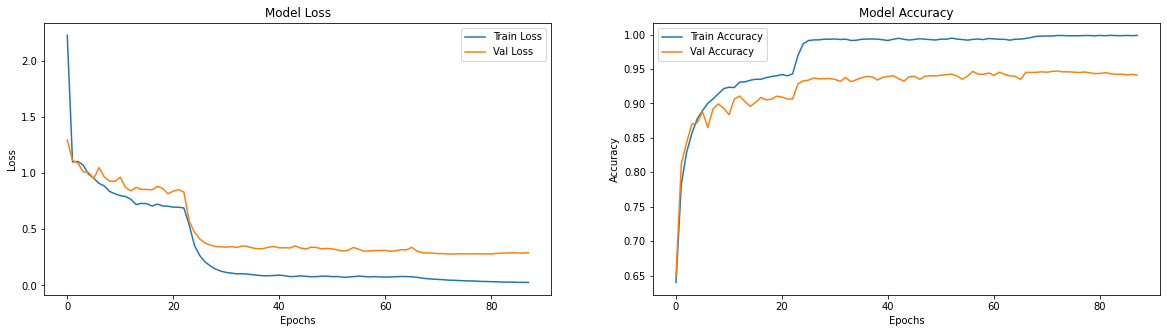

In [51]:
plt.figure(figsize=(20,5))
ax = plt.subplot(1,2,1)
ax.set_title("Model Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(train_loss , label ="Train Loss")
plt.plot(val_loss, label ="Val Loss")
plt.legend()

ax = plt.subplot(1,2,2)
ax.set_title("Model Accuracy")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(train_acc, label = "Train Accuracy")
plt.plot(val_acc, label = "Val Accuracy")
plt.legend()
plt.show();

In [53]:
evaluation = cnn_model.evaluate(train_data,train_tensor)
print("Train Loss: %f"%evaluation[0] , "Train Accuracy: %f"%evaluation[1])

1054/1054 [==============================] - 50s 48ms/step - loss: 0.0749 - accuracy: 0.9879
Train Loss: 0.074931 Train Accuracy: 0.987865


In [57]:
Y_test

37139    positive
19866    negative
34580     neutral
3601     negative
15322    negative
           ...   
27737    positive
27577    negative
10689    positive
36890    negative
8501     positive
Name: sentiment, Length: 8427, dtype: object

In [60]:
test_labels = Y_test
label_encoder = LabelEncoder()
label_encoder.fit(Y_test)
test_labels = label_encoder.transform(test_labels)

test_tensor = to_categorical(np.array(test_labels))

loss, accuracy = cnn_model.evaluate(test_data, test_tensor)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.9478


In [61]:
loss, accuracy = best_weights_cnn.evaluate(test_data, test_tensor)
print("Testing Accuracy:  {:.4f}".format(accuracy))

264/264 [==============================] - 13s 50ms/step - loss: 0.2691 - accuracy: 0.9504
Testing Accuracy:  0.9504


In [62]:
file_path

'models/cnn_weights.hdf5'

In [63]:
files.download(file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [56]:
# with best weight
best_weights_cnn = load_model(file_path)
evaluation = best_weights_cnn.evaluate(train_data,train_tensor)
print("Train Loss: %f"%evaluation[0] , "Train Accuracy: %f"%evaluation[1])

1054/1054 [==============================] - 51s 48ms/step - loss: 0.0885 - accuracy: 0.9890
Train Loss: 0.088476 Train Accuracy: 0.988963
